# A Basic Weather Model made using XGBoost

A simple weather model using XGBoost.

In [ ]:
import sys
!{sys.executable} -m pip install xgboost
!pip install shap


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

weather = pd.read_csv("Refined Datasets/Merged_DataSets.csv",index_col=1, encoding='latin1' )
weather.head(10)

,name,humidity,precip,windspeed,cloudcover,visibility,tempmax c,tempmin c,avgtemp c,feelslikemax c,feelslikemin c,avgfeelsliketemp c,dewpoint c,precip_chance
datetime,,,,,,,,,,,,,,
2005-01-01,Arima,92.8,33.6296,10.3,87.1,6.4,29.0,24.1,25.4,34.6,24.1,26.2,24.1,1
2005-01-02,Arima,78.9,6.1722,13.8,64.6,7.8,32.0,23.1,26.6,34.2,23.1,27.5,22.1,1
2005-01-03,Arima,81.5,0.4826,8.1,54.8,8.4,31.8,22.1,25.5,34.0,22.1,26.4,21.8,1
2005-01-04,Arima,93.2,12.1666,11.4,83.1,6.8,29.2,23.1,24.6,33.7,23.1,25.1,23.3,1
2005-01-05,Arima,83.2,0.7874,4.7,77.9,16.8,31.3,23.7,25.1,33.4,23.7,25.3,21.8,1
2005-01-06,Arima,83.2,2.1590,10.3,92.5,9.8,30.2,24.6,26.6,34.7,24.6,27.7,23.3,1
2005-01-07,Arima,90.5,10.7950,16.1,95.0,4.4,27.1,23.1,24.9,30.4,23.1,25.7,23.2,1
2005-01-08,Arima,81.3,8.8138,10.3,90.0,10.0,29.2,24.1,26.4,32.7,24.1,28.0,22.7,1
2005-01-09,Arima,78.5,0.0000,12.8,81.6,9.5,30.1,23.7,27.3,34.2,23.7,29.5,23.1,0


In [3]:
weather.apply(pd.isnull).sum()

name                  0
humidity              0
precip                0
windspeed             0
cloudcover            0
visibility            0
tempmax c             0
tempmin c             0
avgtemp c             0
feelslikemax c        0
feelslikemin c        0
avgfeelsliketemp c    0
dewpoint c            0
precip_chance         0
dtype: int64

In [5]:
weather.dtypes

name                   object
humidity              float64
precip                float64
windspeed             float64
cloudcover            float64
visibility            float64
tempmax c             float64
tempmin c             float64
avgtemp c             float64
feelslikemax c        float64
feelslikemin c        float64
avgfeelsliketemp c    float64
dewpoint c            float64
precip_chance           int64
dtype: object

In [7]:
weather.index

Index(['2005-01-01', '2005-01-02', '2005-01-03', '2005-01-04', '2005-01-05',
       '2005-01-06', '2005-01-07', '2005-01-08', '2005-01-09', '2005-01-10',
       ...
       '2025-04-19', '2025-04-20', '2025-04-21', '2025-04-22', '2025-04-23',
       '2025-04-24', '2025-04-25', '2025-04-26', '2025-04-27', '2025-04-28'],
      dtype='object', name='datetime', length=119046)

In [9]:
weather.index = pd.to_datetime(weather.index)
weather.index

DatetimeIndex(['2005-01-01', '2005-01-02', '2005-01-03', '2005-01-04',
               '2005-01-05', '2005-01-06', '2005-01-07', '2005-01-08',
               '2005-01-09', '2005-01-10',
               ...
               '2025-04-19', '2025-04-20', '2025-04-21', '2025-04-22',
               '2025-04-23', '2025-04-24', '2025-04-25', '2025-04-26',
               '2025-04-27', '2025-04-28'],
              dtype='datetime64[ns]', name='datetime', length=119046, freq=None)

<Axes: xlabel='datetime'>

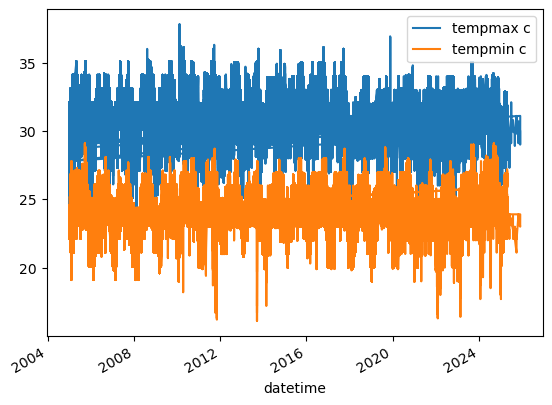

In [11]:
weather[["tempmax c", "tempmin c"]].plot()

# Train Test Split

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
weather['location_encoded'] = le.fit_transform(weather['name'])

weather.columns

Index(['name', 'humidity', 'precip', 'windspeed', 'cloudcover', 'visibility',
       'tempmax c', 'tempmin c', 'avgtemp c', 'feelslikemax c',
       'feelslikemin c', 'avgfeelsliketemp c', 'dewpoint c', 'precip_chance',
       'location_encoded'],
      dtype='object')

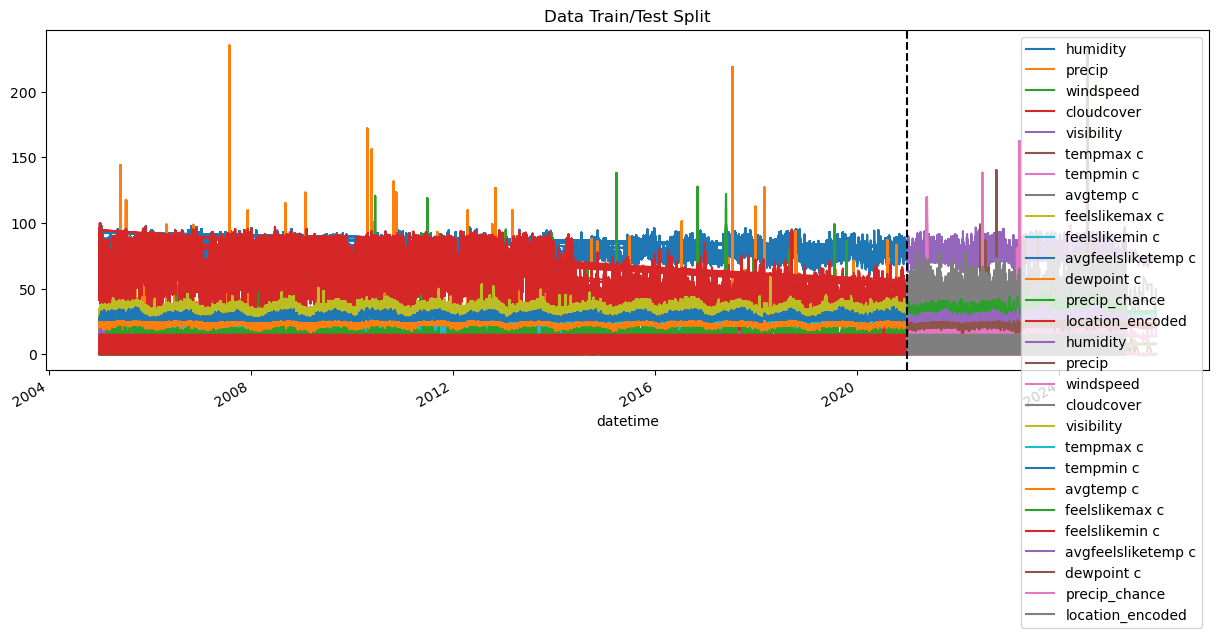

In [16]:
train = weather.loc[weather.index < '01-01-2021']
test = weather.loc[weather.index > '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
plt.show()

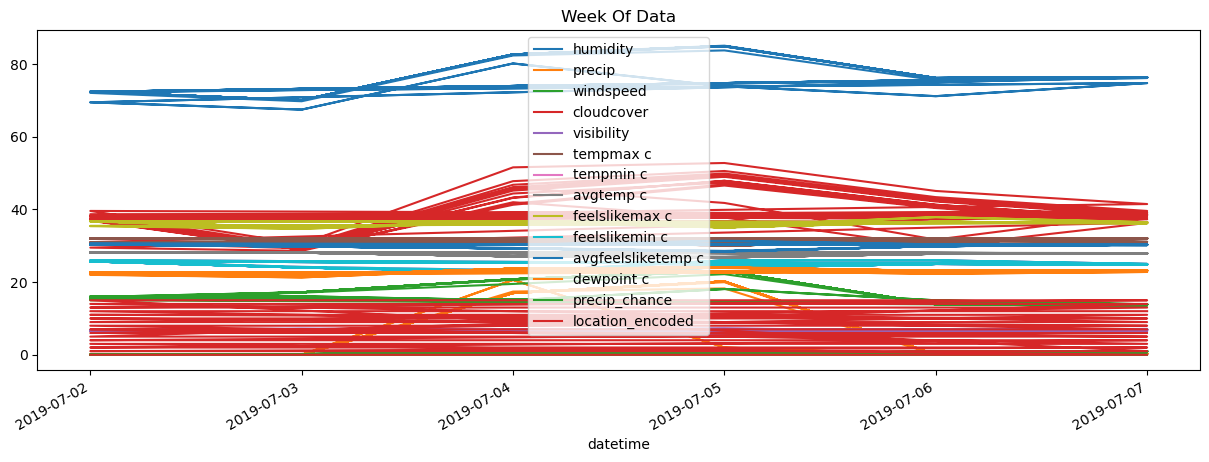

In [17]:
weather.loc[(weather.index > '07-01-2019') & (weather.index < '07-08-2019')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Create features 

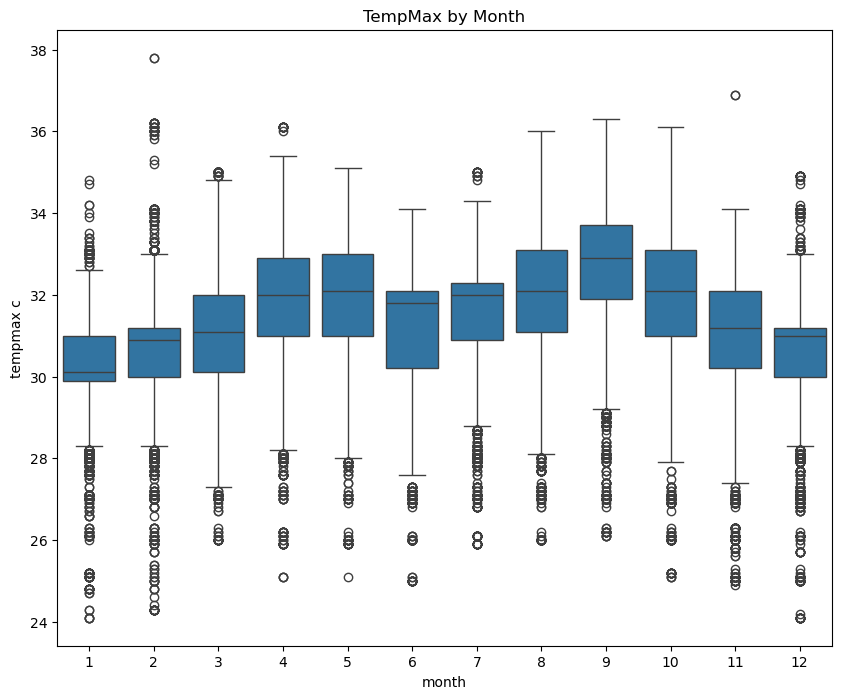

In [21]:
df = weather.copy()
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='tempmax c')
ax.set_title('TempMax by Month')
plt.show()

Index(['name', 'humidity', 'precip', 'windspeed', 'cloudcover', 'visibility',
       'tempmax c', 'tempmin c', 'avgtemp c', 'feelslikemax c',
       'feelslikemin c', 'avgfeelsliketemp c', 'dewpoint c', 'precip_chance',
       'location_encoded'],
      dtype='object')


<bound method Axes.set_title of <Axes: xlabel='month', ylabel='tempmin c'>>

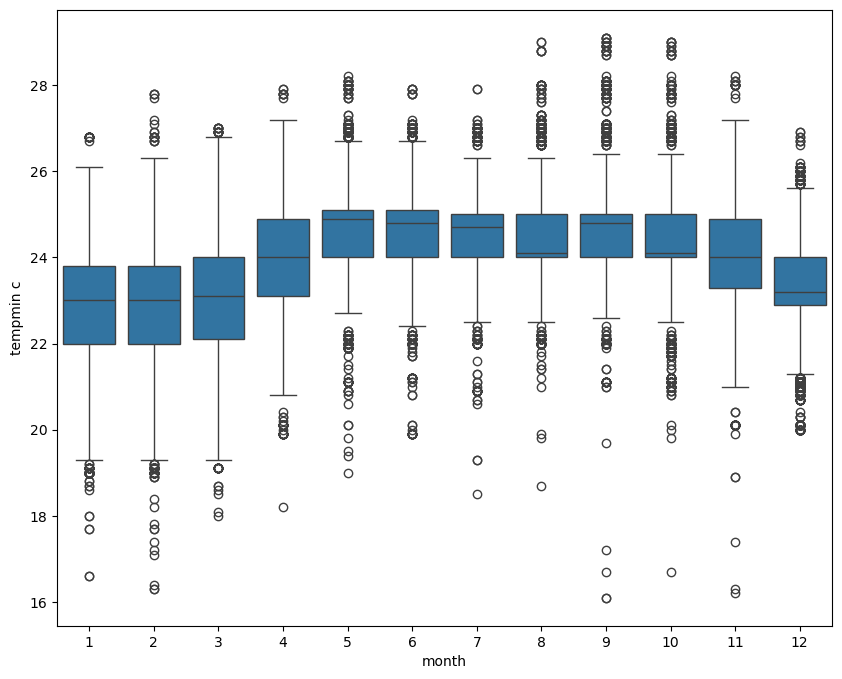

In [23]:
print(weather.columns)
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    return df
df = create_features(weather)

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='tempmin c')
ax.set_title

In [25]:
df.tail(10)

,name,humidity,precip,windspeed,cloudcover,visibility,tempmax c,tempmin c,avgtemp c,feelslikemax c,feelslikemin c,avgfeelsliketemp c,dewpoint c,precip_chance,location_encoded,dayofweek,dayofyear,month,year
datetime,,,,,,,,,,,,,,,,,,,
2025-04-19,San Juan-Laventille,73.4,0.3048,17.2,49.1,6.6,31.1,25.9,28.1,34.4,25.9,30.2,22.7,1,12,5,109,4,2025
2025-04-20,San Juan-Laventille,76.6,0.0000,16.1,51.9,6.4,31.9,24.1,27.6,37.6,24.1,29.6,22.8,0,12,6,110,4,2025
2025-04-21,San Juan-Laventille,77.3,10.0076,13.9,40.5,6.6,32.8,23.8,26.2,34.8,23.8,26.8,21.5,1,12,0,111,4,2025
2025-04-22,San Juan-Laventille,85.0,97.0026,13.9,46.1,7.0,31.1,22.1,25.7,36.6,22.1,27.2,22.9,1,12,1,112,4,2025
2025-04-23,San Juan-Laventille,80.4,0.2032,11.4,58.9,7.1,30.8,24.0,26.8,35.3,24.0,28.7,23.1,1,12,2,113,4,2025
2025-04-24,San Juan-Laventille,87.2,18.5928,11.4,64.5,5.2,28.1,25.1,26.4,32.0,25.1,27.7,24.1,1,12,3,114,4,2025
2025-04-25,San Juan-Laventille,75.7,0.0000,15.0,46.0,7.6,30.9,25.0,27.7,35.2,25.0,29.6,22.8,0,12,4,115,4,2025
2025-04-26,San Juan-Laventille,72.7,0.0000,16.1,34.9,7.5,31.8,24.8,27.5,34.7,24.8,29.1,21.9,0,12,5,116,4,2025
2025-04-27,San Juan-Laventille,72.6,0.0000,15.0,47.4,7.9,30.1,24.1,27.1,32.6,24.1,28.5,21.6,0,12,6,117,4,2025


In [27]:
location_range = df['location_encoded'].unique()
print(len(location_range))
print(location_range)

16
[ 0  3  8 10 11  6  4  2  1 15 13  9 14  5  7 12]


In [29]:
train = create_features(train)
test = create_features(test)

# XGBoost Model: Chained Multi-Model 


In [32]:
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [34]:
# Columns to predict
target_features = ['cloudcover', 'precip','humidity', 'windspeed','feelslikemax c','tempmax c', 'tempmin c', 
                'avgtemp c','feelslikemin c', 'avgfeelsliketemp c','dewpoint c', 'visibility']

#features used to build the model
core_features = ['location_encoded', 'dayofweek', 'dayofyear', 'month', 'year']

#blank DataFrame for the model predictions
predictions = pd.DataFrame(index=df.index)

#Dict to store each model
models = {}

In [36]:
def train_model(df, target, core_features, prev_predictions=None, models={}):
   
    X = df[core_features]
    y = df[target].astype(float).values.ravel()

    print(f"\n Training model to predict: {target}")
    
    if prev_predictions is not None:
        prev_predictions = prev_predictions.loc[:, ~prev_predictions.columns.isin(X.columns)]
        X = pd.concat([X, prev_predictions], axis=1)

    model = xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)
    model.fit(X, y)
    
    y_pred = model.predict(X)

    print(f"{target} MAE: {mean_absolute_error(y, y_pred):.3f}")

    joblib.dump(model, f"Models/{target}_model.pkl")
    print(f"Model Saved")

    models[target] = model

    return y_pred

In [38]:
for i, target in enumerate(target_features):
    prev = predictions if i > 0 else None
    y_pred = train_model(df, target, core_features, prev, models)
    predictions[f'pred_{target}'] = y_pred


 Training model to predict: cloudcover
cloudcover MAE: 5.629
Model Saved

 Training model to predict: precip
precip MAE: 3.250
Model Saved

 Training model to predict: humidity
humidity MAE: 1.917
Model Saved

 Training model to predict: windspeed
windspeed MAE: 1.616
Model Saved

 Training model to predict: feelslikemax c
feelslikemax c MAE: 0.769
Model Saved

 Training model to predict: tempmax c
tempmax c MAE: 0.382
Model Saved

 Training model to predict: tempmin c
tempmin c MAE: 0.408
Model Saved

 Training model to predict: avgtemp c
avgtemp c MAE: 0.216
Model Saved

 Training model to predict: feelslikemin c
feelslikemin c MAE: 0.298
Model Saved

 Training model to predict: avgfeelsliketemp c
avgfeelsliketemp c MAE: 0.306
Model Saved

 Training model to predict: dewpoint c
dewpoint c MAE: 0.210
Model Saved

 Training model to predict: visibility
visibility MAE: 0.261
Model Saved


In [40]:
def predict_for_date(input_df, models, target_order):
    input_copy = input_df.copy()
    preds = {}

    for target in target_order:
        model = models[target]
        prediction = model.predict(input_copy)
        preds[target] = prediction
        input_copy[f'pred_{target}'] = prediction

    return preds

In [42]:
from datetime import datetime

def prepare_input_from_date(date_str, location_encoded):
    dt = datetime.strptime(date_str, "%d-%m-%Y")
    return pd.DataFrame([{
        'location_encoded': location_encoded,
        'dayofweek': dt.weekday(),
        'dayofyear': dt.timetuple().tm_yday,
        'month': dt.month,
        'year': dt.year
    }])

In [44]:
def print_predictions(preds):
    print("Predictions:")
    for key, val in preds.items():
        print(f"{key:<20}: {val[0]:.2f}")

In [56]:
#dd-mm-yyyy
date_str = "05-07-2025"
location_encoded = 10
input_df = prepare_input_from_date(date_str, location_encoded)
preds = predict_for_date(input_df, models, target_features)

print_predictions(preds)

Predictions:
cloudcover          : 47.08
precip              : -1.21
humidity            : 75.52
windspeed           : 13.65
feelslikemax c      : 31.62
tempmax c           : 29.30
tempmin c           : 23.20
avgtemp c           : 25.94
feelslikemin c      : 23.00
avgfeelsliketemp c  : 26.88
dewpoint c          : 21.05
visibility          : 7.30


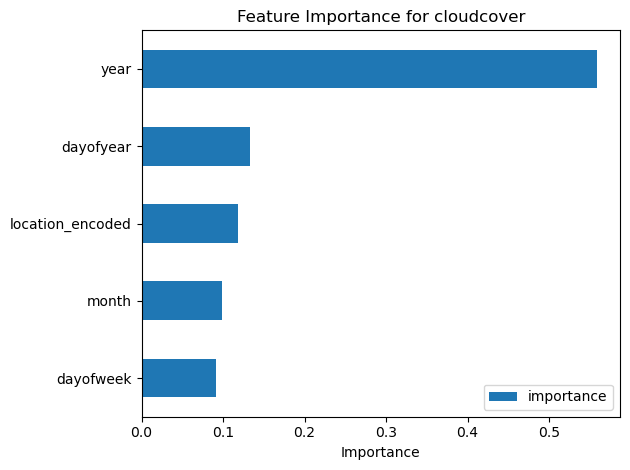

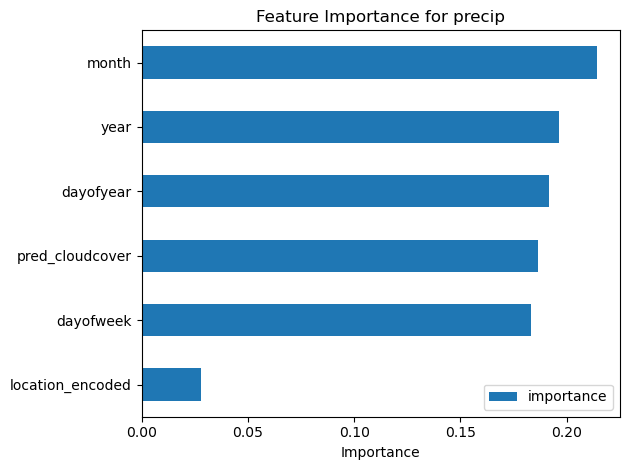

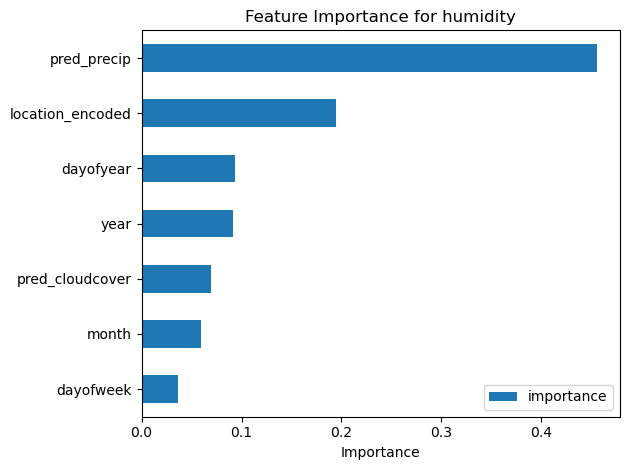

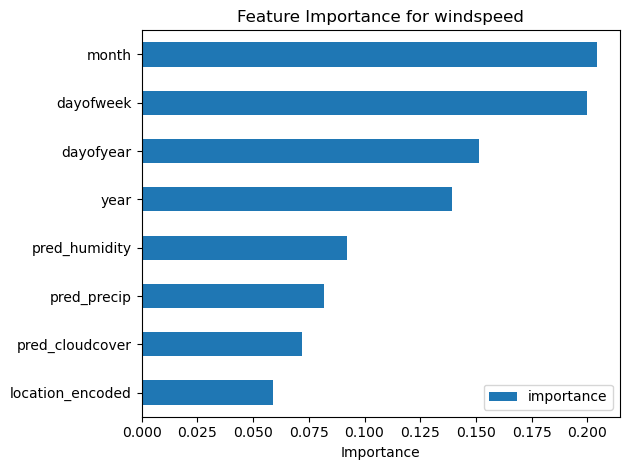

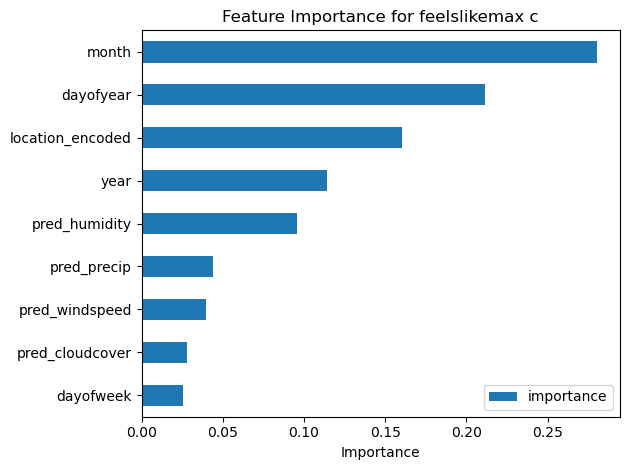

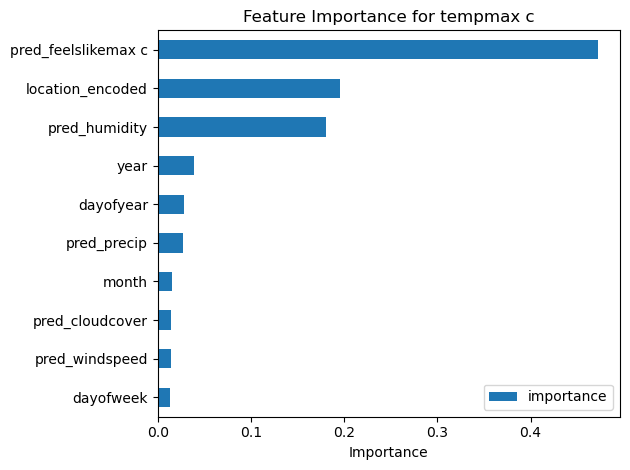

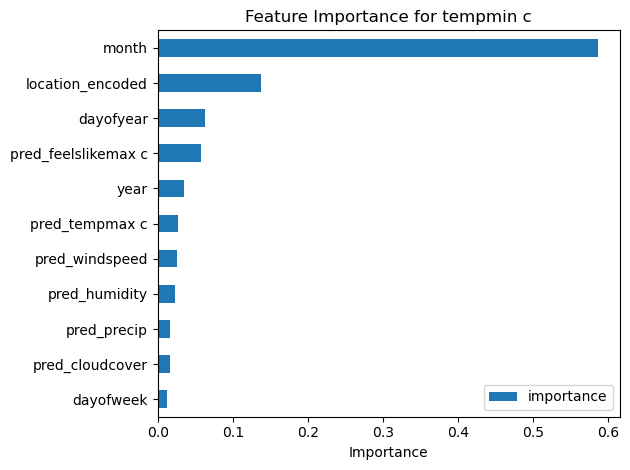

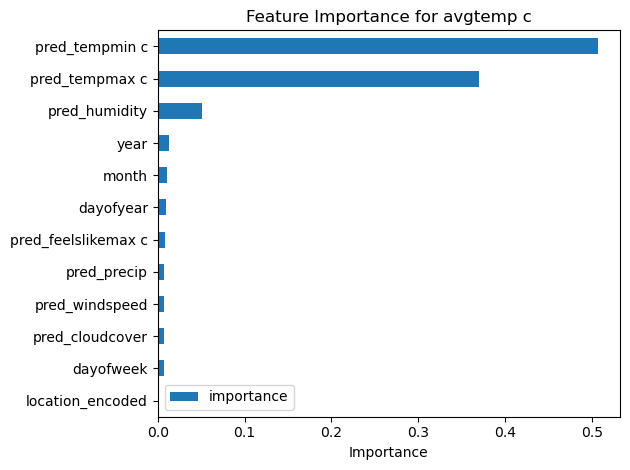

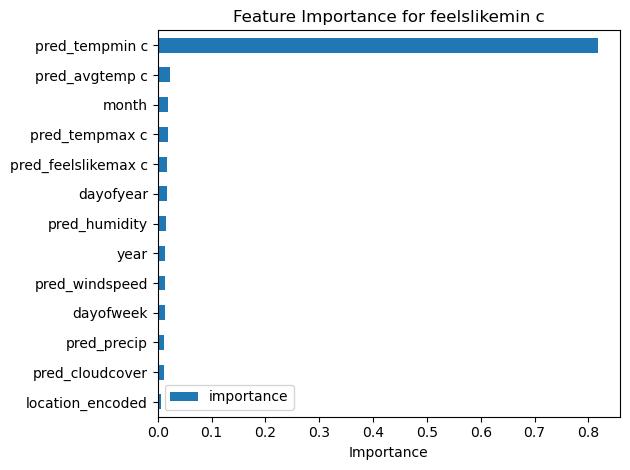

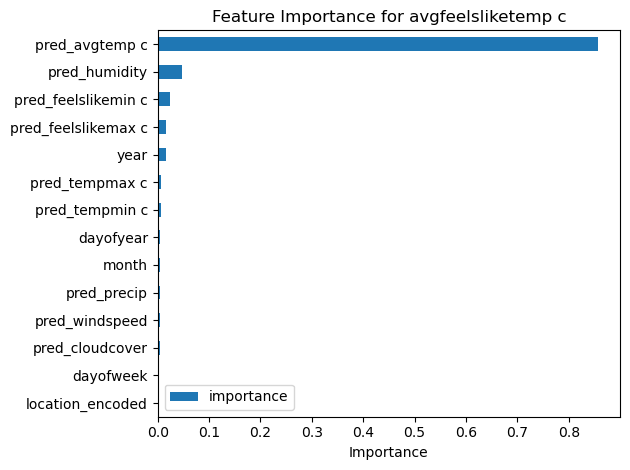

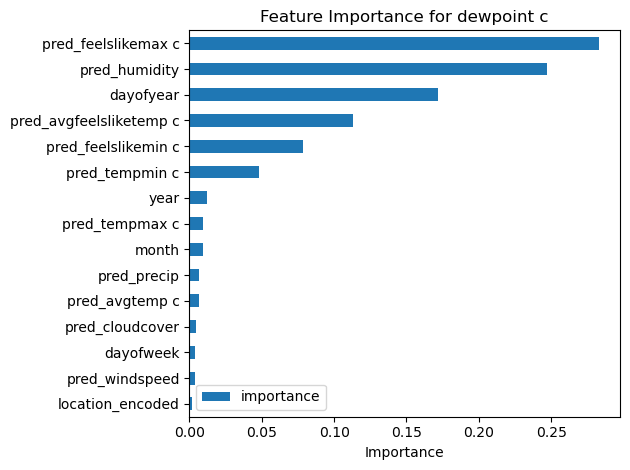

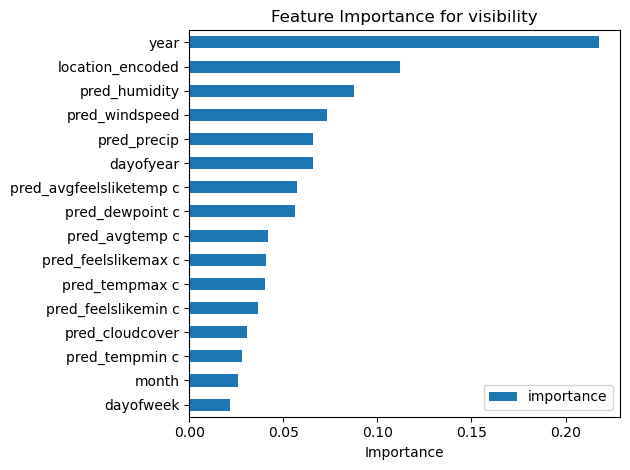

In [48]:
for target, model in models.items():
    fi = pd.DataFrame(data=model.feature_importances_,index=model.feature_names_in_,columns=['importance'])
    
    fi = fi.sort_values('importance', ascending=True)
    fi.plot(kind='barh', title=f'Feature Importance for {target}')
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

In [58]:
from sklearn.metrics import mean_absolute_error

predictions = pd.DataFrame(index=df.index)
accuracies = []

for target in models.keys():
    model = models[target]

    # Base features
    X = df[core_features].copy()

    # Adding prior predictions
    if not predictions.empty:
        X = pd.concat([X, predictions], axis=1)

    # Match model's expected features
    model_features = model.feature_names_in_
    X = X[model_features]

    # Predict
    y_true = df[target].astype(float).values.ravel()
    y_pred = model.predict(X)

    # Save prediction
    predictions[f'pred_{target}'] = y_pred

    # Calculate accuracy based on MAE relative to y_true range
    mae = mean_absolute_error(y_true, y_pred)
    value_range = y_true.max() - y_true.min()
    if value_range == 0:
        accuracy = 100.0  # avoid divide-by-zero
    else:
        accuracy = 100 - ((mae / value_range) * 100)

    accuracies.append(accuracy)
    print(f"{target} Accuracy: {accuracy:.2f}%")

# Average across all targets
avg_accuracy = sum(accuracies) / len(accuracies)
print(f"\nAverage Accuracy Across Models: {avg_accuracy:.2f}%")

cloudcover Accuracy: 93.66%
precip Accuracy: 98.62%
humidity Accuracy: 95.45%
windspeed Accuracy: 99.00%
feelslikemax c Accuracy: 97.79%
tempmax c Accuracy: 97.21%
tempmin c Accuracy: 96.86%
avgtemp c Accuracy: 97.37%
feelslikemin c Accuracy: 98.47%
avgfeelsliketemp c Accuracy: 98.17%
dewpoint c Accuracy: 97.90%
visibility Accuracy: 98.58%

Average Accuracy Across Models: 97.42%
